# TO-DOs:

[x] Clustering of covariates according to correlation structure

[x] Removing uncorrelated covariates

[ ] Possibility for prior? Starting Values?

# Hierachical Clustering of Correlations

Requirements:
See imports.

Links:

1. https://github.com/TheLoneNut/CorrelationMatrixClustering/blob/master/CorrelationMatrixClustering.ipynb
2. https://stats.stackexchange.com/questions/138325/clustering-a-correlation-matrix
3. https://en.wikipedia.org/wiki/Correlation_clustering
4. https://thelonenutblog.wordpress.com/2017/03/30/correlation-matrix-clustering/

In [143]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

from scipy.linalg import block_diag
from string import ascii_letters

## Functions to Simulate Block Correlation Matrices

The function ``simulate_empirical_correlation_matrix`` simulates data with specific group (block) correlation structure and return the emprical correlation matrix. It takes as input the number of observations of simulated individuals (``nobs``) and the group structure of the correlation matrix. This is given by ``num_members`` and ``correlations``; The first argument (``num_members``) specifies the number of covariates in a group, i.e. ``num_members = [4, 5]`` means that the first group has 4 correlated covariates and the second group has 5, while the covariates in the first and second group are not correlated. The second parameter (``correlations``) gives the correlation between group members for a given group, i.e. ``correlations = [0.4, 0.2]`` means that the correlations within the first group are 0.4 and the correlations within the second group are 0.2.

In [120]:
def simulate_empirical_correlation_matrix(nobs, num_members, correlations, seed):
    """Simulate a data set and its correlation matrix using a specific correlation 
    group structure.
    
    Args:
        nobs (int): Number of observations.
        num_members (list): List of integers, specifying the numbers of correlated
            covariates in a group. Number of groups = len(num_members). Length of
            num_members has to be equal to length of correlations.
        correlations (list): List of floats in [0, 1].
        seed (int): Random number seed.
        
    Returns:
        cm, cmcm, X, XX (np.array):
            - cm: Correlation matrix (ordered).
            - cmcm: Shuffled correlation matrix (unordered).
            - X: (Ordered) data set.
            - XX: (Unordered) data set.
        
    """
    X = simulate_normal_data(nobs, num_members, correlations, seed)
    cm = np.corrcoef(X.T)
    
    num_features = X.shape[1]
    shuffle_index = np.random.permutation(np.arange(num_features))
    XX = X[:, shuffle_index]
    
    cmcm = np.corrcoef(XX.T)
    return cm, cmcm, X, XX

In [121]:
def simulate_normal_data(nobs, num_members, correlations, seed):
    """Simulate normal data with specific group correlation structure. 
    
    Args:
        nobs (int): Number of observations.
        num_members (list): List of integers, specifying the numbers of correlated
            covariates in a group. Number of groups = len(num_members). Length of
            num_members has to be equal to length of correlations.
        correlations (list): List of floats in [0, 1].
        seed (int): Random number seed.

    Returns:
    
    
    """
    np.random.seed(seed)
    dimension = int(sum(num_members))
    cov = create_block_correlation_matrix(num_members, correlations)
    X = np.random.multivariate_normal(mean=np.zeros(dimension), cov=cov, size=nobs)
    return X

In [122]:
def create_block_correlation_matrix(num_members, correlations):
    """Create correlation matrix with block structure.
    
    Args:
        num_members (list): List of integers, specifying the numbers of correlated
            covariates in a group. Number of groups = len(num_members). Length of
            num_members has to be equal to length of correlations.
        correlations (list): List of floats in [0, 1].
    
    """
    matrices = [create_correlation_matrix(dim, corr) for dim, corr in zip(num_members, correlations)]
    block_matrix = block_diag(*matrices)
    return block_matrix

In [123]:
def create_correlation_matrix(dim, correlation):
    """Create simple correlation matrix.
    
    Create simple correlation matrix with size (dim, dim)
    and off-diagonal correlation given by correlation.
    
    Args:
        dim (int): Dimension.
        correlation (float): Positive float representing the off-diagonal
            correlation.
    
    """
    mat = np.full((dim, dim), correlation)
    np.fill_diagonal(mat, 1)
    return mat

## Functions to Plot Correlation Matrix as Heatmap

In [124]:
def plot_correlation_heatmap(corrmat, figsize=(11, 9)):
    """Plot correlation matrix as heatmap."""
    sns.set(style="white")
    mask = np.triu(np.ones_like(corrmat, dtype=np.bool))
    f, ax = plt.subplots(figsize=figsize)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corrmat, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Functions to Cluster the Correlations into Groups

In [125]:
def find_clusters_correlation_matrix(
        corrmat,
        remove_uncorrelated_features=False,
        threshold=0.05,
        return_clustered_corrmat=False
):
    """Find clusters in correlation matrix using hierachical clustering.
    
    Args:
        corrmat (np.array): The correlation matrix.
        remove_uncorrelated_features: Should features with maximum correlation
            less than ``threshold`` be dropped.
        threshold (float): Positive threshold in (0, 1) determining the number of
            features to drop if ``remove_uncorrelated_features`` is True.
        return_clustered_corrmat (bool): Should the reordered corrmat be returned.
        
    Returns:
        out (dict): Dictionary containing:
            - index (np.array): 
                Index to reorder features
            - relevant_features (np.array):
                Index to reorder features where irrelevant features are dropped, if
                return_uncorrelated_features is True.
            - cm (np.array):
                Clustered correlation matrix, if return_clustered_corrmat is True.
            - cm_relevant (np.array):
                Clustered correlation matrix where irrelevant features are dropped, if
                return_uncorrelated_features and return_clustered_corrmat is True.
    """
    # hierachical clustering
    distance = sch.distance.pdist(corrmat)
    linkage = sch.linkage(distance, method='complete')
    index = sch.fcluster(linkage, 0.5 * distance.max(), 'distance')
    index = np.argsort(index)
    
    # reorder features
    cm = corrmat[:, index][index, :].copy()
    
    out = {}
    out['index'] = index
    
    if remove_uncorrelated_features:
        relevant_features = compute_relevant_features(cm, threshold)
        out['relevant_features'] = relevant_features
        
    if return_clustered_corrmat:
        out['cm'] = cm
        if remove_uncorrelated_features:
            cm_relevant = cm[:, relevant_features][relevant_features, :].copy()
            out['cm_relevant'] = cm_relevant

    return out

## What constitutes a relevant feature?

Let $r_{ij}$ denote the (empirical) correlation between feature $i$ and $j$.
The function ``compute_relevant_features`` drops features $i$ for which
$$\max_{j \neq i} \{r_{ij}\} < threshold \,.$$

In [126]:
def compute_relevant_features(corrmat, threshold):
    """Compute indices of relevant features.
    
    Computes which features have a correlation with any other feature
    greater than ``threshold``.
    
    Args:
        corrmat (np.array): The correlation matrix.
        threshold (float): The threshold. Must be in (0, 1).
    
    Returns:
        relevant_features (np.array): Integer array containing the relevant features.
        
    """
    cm_without_diagonal = skip_diag(corrmat)
    max_correlation = cm_without_diagonal.max(axis=0)
    relevant_features = np.where(max_correlation > threshold)[0]
    return relevant_features

In [127]:
def skip_diag(A):
    """Skip diagonal elements of matrix.
    
    Args:
        A (np.array): 2 dim. array of which we want to drop the diagonal elements.
    
    Returns:
        out (np.array): The new 2 dim. array without diagonal elements.
    
    Example:
    > A = np.arange(9).reshape((3, 3))
    > A
    array([[0, 1, 2],
          [3, 4, 5],
          [6, 7, 8]])
    > skip_diag(A)
    array([[3, 1, 2],
           [6, 7, 5]])
           
    """
    AA = A.copy().T
    out = AA[~np.eye(A.shape[0],dtype=bool)].reshape(A.shape[0],-1)
    return out.T

# Example (Simple case):

**Note**: ``cm_block`` and ``X_block`` denote the (correctly) ordered correlation matrix and data, which results in a block correlation matrix.

In [129]:
nobs = 5000
num_members = [10, 7, 6, 13, 20, 17]
correlations = [0.4, 0.3, 0.2, 0.4, 0.5, 0.2]

cm_block, cm, X_block, X = simulate_empirical_correlation_matrix(
    nobs=nobs,
    num_members=num_members,
    correlations=correlations,
    seed=1
)

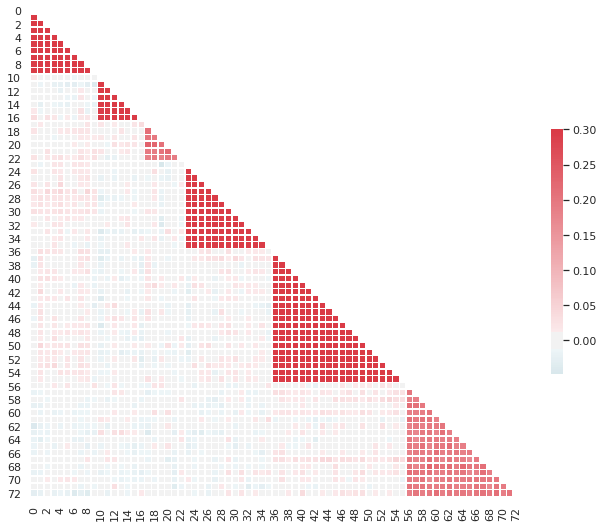

In [131]:
plot_correlation_heatmap(cm_block)

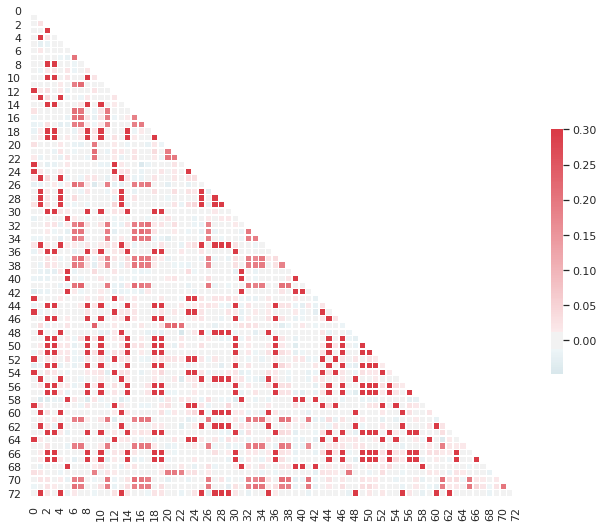

In [132]:
plot_correlation_heatmap(cm)

### Remark: ``cm`` and ``X`` now contain the unordered data!

### Find clusters

In [135]:
result = find_clusters_correlation_matrix(cm, return_clustered_corrmat=True)

### Plot ordered correlation matrix

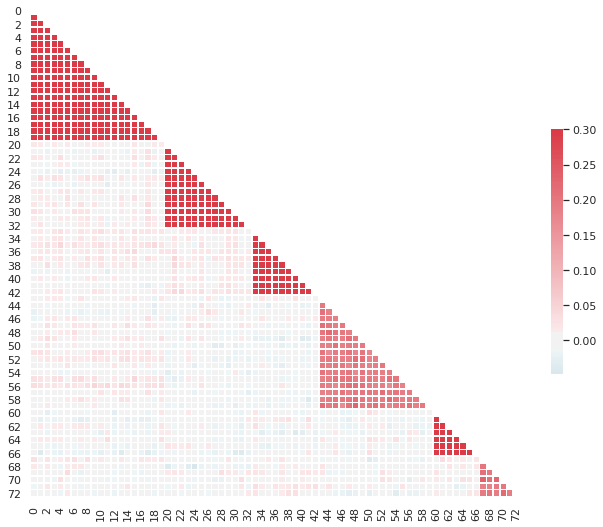

In [136]:
plot_correlation_heatmap(result['cm'])

### Plot ordered correlation matrix using index

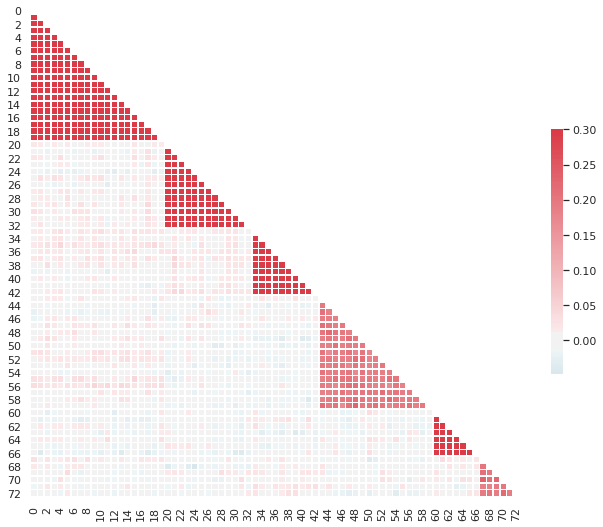

In [137]:
XX = X[:, result['index']]
newcorr = np.corrcoef(XX.T)
plot_correlation_heatmap(newcorr)

# Example (Drop uncorrelated covariates):

**We Want**: In case there are many features that are uncorrelated (or only slightly correlated up to a threshold) with all other features we want to drop these features automatically.

In [138]:
nobs = 5000
num_members = [10, 7, 6, 20, 15]
correlations = [0.4, 0, 0.2, 0.3, 0]

cm_block, cm, X_block, X = simulate_empirical_correlation_matrix(
    nobs=nobs,
    num_members=num_members,
    correlations=correlations,
    seed=1
)

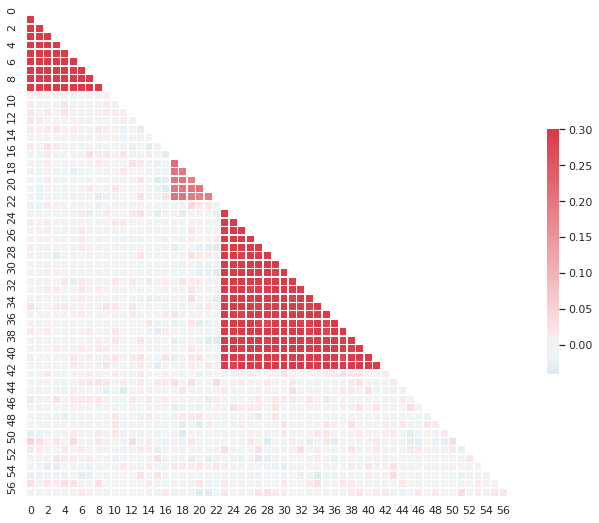

In [139]:
plot_correlation_heatmap(cm_block)

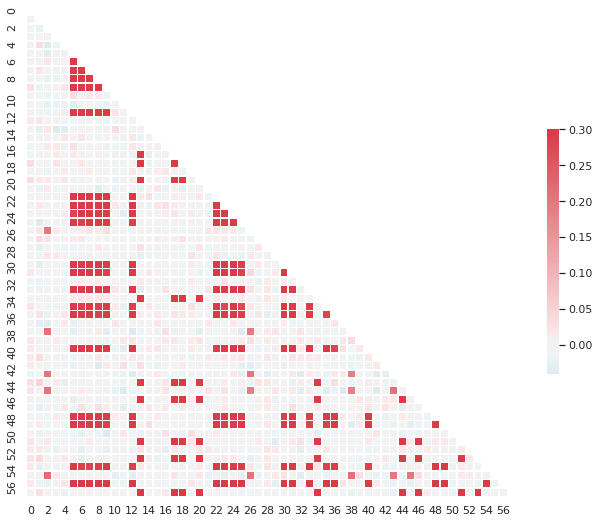

In [140]:
plot_correlation_heatmap(cm)

In [141]:
result = find_clusters_correlation_matrix(
    cm,
    remove_uncorrelated_features=True,
    threshold=0.05,
    return_clustered_corrmat=True
)

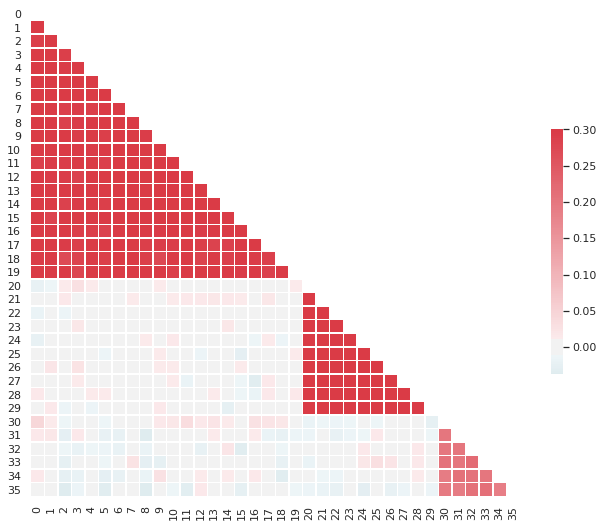

In [142]:
plot_correlation_heatmap(result['cm_relevant'])